In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import function_library_assignment_1 as fnc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #filtering FutureWarnings - we don't need to worry about them in this case
#(This is run using Python 3.9)

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

## Reading data

In [2]:
gen_data = fnc.read_data('gen_data')
demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_costs = fnc.read_data('gen_costs')
line_data = fnc.read_data('line_data')
branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data')
all_bid_prices = fnc.read_data('all_bid_prices')

GC = len(gen_data.index)
GW = len(wind_data.columns)
G = GC + GW
D = len(load_distribution.index)
N = 24 # number of buses

WF_NODES = [2, 4, 6, 15, 20, 22] # zero-indexed

t = 17 #hour

Set up demand array for the hour

In [3]:
load = np.zeros(N)

#Saving the load for each bus in a numpy array accounting for the system load distribution
for n in load_distribution['Node'].unique():
    load[n-1] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * demand[t] #remember that the data is not 0-indexed but the arrays are
load

array([100.719 ,  90.117 , 166.9815,  68.913 ,  66.2625, 127.224 ,
       116.622 , 159.03  , 161.6805, 180.234 ,   0.    ,   0.    ,
       246.4965, 180.234 , 294.2055,  92.7675,   0.    , 310.1085,
       169.632 , 119.2725,   0.    ,   0.    ,   0.    ,   0.    ])

Setup bid prices for loads

In [4]:
bid_prices = np.zeros(D)

for n in range(D):
    bid_prices[n] = all_bid_prices.loc[all_bid_prices['Load #'] == (n + 1), f't{t+1}']
    print(f'Load {n+1} bid price: {bid_prices[n]} $/MWh')

Load 1 bid price: 22.0 $/MWh
Load 2 bid price: 24.0 $/MWh
Load 3 bid price: 25.0 $/MWh
Load 4 bid price: 25.0 $/MWh
Load 5 bid price: 23.0 $/MWh
Load 6 bid price: 24.0 $/MWh
Load 7 bid price: 17.0 $/MWh
Load 8 bid price: 20.0 $/MWh
Load 9 bid price: 16.0 $/MWh
Load 10 bid price: 10.0 $/MWh
Load 11 bid price: 10.0 $/MWh
Load 12 bid price: 21.0 $/MWh
Load 13 bid price: 25.0 $/MWh
Load 14 bid price: 18.0 $/MWh
Load 15 bid price: 20.0 $/MWh
Load 16 bid price: 10.0 $/MWh
Load 17 bid price: 11.0 $/MWh


## Setup Gurobi model

In [5]:
direction = gb.GRB.MAXIMIZE #Min / Max

m = gb.Model() # Create a Gurobi model  

#============= Variables =============
p_G = m.addVars(G, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="P_G") #Note: wind farms can be curtailed AND P_min from the system should be disregarded to avoid having a mixed integer program
p_D = m.addVars(D, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="P_D") #Note: demands are elastic

#============= Objective function =============
# Set objective function (social welfare) - note that production cost of wind farms is assumed to be zero
obj = gb.quicksum(bid_prices[d] * p_D[d] for d in range(D)) - gb.quicksum(gen_costs['C ($/MWh)'][k] * p_G[k] for k in range(GC))
m.setObjective(obj, direction)

#============= Balance equation =============
m.addConstr(gb.quicksum(p_D[d] for d in range(D)) - gb.quicksum(p_G[g] for g in range(G)) == 0)

#============= Generator limits ============

#Upper limits
m.addConstrs(p_G[g] <= (gen_data['P max MW'].iloc[g]) for g in range(GC)) #conventinal generator upper limits

#Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
m.addConstrs(p_G[GC + g] <= wind_data.iloc[t, g] for g in range(GW)) #wind farm generator upper limits

#Lower limits (coded as constraints to be able to extract dual values for KKTs)
m.addConstrs(-p_G[g] <= 0 for g in range(G))

#============= Demand limits ===============
m.addConstrs(p_D[d] <= load[load != 0][d] for d in range(D)) #demand upper limits
m.addConstrs(-p_D[d] <= 0 for d in range(D))

#============= Display and run model =============
m.update()
m.display()
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-28
Maximize
-13.32 P_G[0] + -13.32 P_G[1] + -20.7 P_G[2] + -20.93 P_G[3] + -26.11 P_G[4] +
-10.52 P_G[5] + -10.52 P_G[6] + -6.02 P_G[7] + -5.47 P_G[8] + -10.52 P_G[10] +
-10.89 P_G[11] + 22.0 P_D[0] + 24.0 P_D[1] + 25.0 P_D[2] + 25.0 P_D[3] + 23.0 P_D[4]
+ 24.0 P_D[5] + 17.0 P_D[6] + 20.0 P_D[7] + 16.0 P_D[8] + 10.0 P_D[9] + 10.0 P_D[10]
+ 21.0 P_D[11] + 25.0 P_D[12] + 18.0 P_D[13] + 20.0 P_D[14] + 10.0 P_D[15] + 11.0 P_D[16]
Subject To
R0: -1.0 P_G[0] + -1.0 P_G[1] + -1.0 P_G[2] + -1.0 P_G[3] + -1.0 P_G[4] + -1.0 P_G[5] +
-1.0 P_G[6] + -1.0 P_G[7] + -1.0 P_G[8] + -1.0 P_G[9] + -1.0 P_G[10] + -1.0 P_G[11] +
-1.0 P_G[12] + -1.0 P_G[13] + -1.0 P_G[14] + -1.0 P_G[15] + -1.0 P_G[16] + -1.0 P_G[17]
+ P_D[0] + P_D[1] + P_D[2] + P_D[3] + P_D[4] + P_D[5] + P_D[6] + P_D[7] + P_D[8] +
 P_D[9] + P_D[10] + P_D[11] + P_D[12] + P_D[13] + P_D[14] + P_D[15] + P_D[16] = 0
  R1: P_G[0] <= 152
  R2: P_G[1] <= 152
  R3

## Analyze results

In [6]:
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    #initialization
    results = {}
    generator_outputs = pd.DataFrame(data=np.zeros(G), columns=['p_G'])
    generator_outputs['Node'] = 0
    generator_outputs['Dispatched Percentage'] = 0
    generator_outputs['Type'] = 'Conventional'

    load_results = pd.DataFrame(data=np.zeros(D), columns=['p_D'])
    load_results['Node'] = load_distribution['Node'].values
    load_results['Maximum Demand'] = load[load != 0]
    load_results['Covered Percentage'] = 0

    #get dual values
    constraints = m.getConstrs()
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 

    #Generator results
    for i in range(G):
        print(p_G[i].VarName + ": %.2f MW" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x

        if i < GC: #conventional units
            generator_outputs.loc[generator_outputs.index == i, 'Node'] = gen_data.loc[gen_data.index == i, 'Node'].values #save node
            gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
            generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i].x / gen_limit) * 100
        else: #wind units
            generator_outputs.loc[generator_outputs.index == i, 'Node'] = WF_NODES[i - GC] + 1 #save node (from zero-indexed to 1-indexed)
            wind_limit = wind_data.iloc[t, i - GC]
            generator_outputs.loc[generator_outputs.index == i, 'Dispatched Percentage'] = (p_G[i].x / wind_limit) * 100
            generator_outputs.loc[generator_outputs.index == i, 'Type'] = 'Wind'

    #Demand results
    for i in range(D):
        print(p_D[i].VarName + ": %.2f MW" % p_D[i].x)
        load_results.loc[load_results.index == i, 'p_D'] = p_D[i].x
        load_results.loc[load_results.index == i, 'Covered Percentage'] = (p_D[i].x / load[load != 0][i]) * 100

    print('-----------------------------------------------')

    sum_gen = sum(p_G[n].x for n in range(G))
    sum_load = sum(p_D[n].x for n in range(D))
    lambda_sol = m.Pi[0]
    print("Total load: %.1f MWh" % sum_load)
    print("Total generation: %.1f MWh" % sum_gen)

    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m.objVal)
    print("Lambda: %.2f $/MWh" % m.Pi[0])

    results['gen'] = generator_outputs.copy(deep=True)
    results['demand'] = load_results.copy(deep=True)

else:
    print("Optimization was not successful.")     

P_G[0]: 0.00 MW
P_G[1]: 0.00 MW
P_G[2]: 0.00 MW
P_G[3]: 0.00 MW
P_G[4]: 0.00 MW
P_G[5]: 155.00 MW
P_G[6]: 103.87 MW
P_G[7]: 400.00 MW
P_G[8]: 400.00 MW
P_G[9]: 300.00 MW
P_G[10]: 310.00 MW
P_G[11]: 0.00 MW
P_G[12]: 64.11 MW
P_G[13]: 51.01 MW
P_G[14]: 78.37 MW
P_G[15]: 65.47 MW
P_G[16]: 66.54 MW
P_G[17]: 59.77 MW
P_D[0]: 100.72 MW
P_D[1]: 90.12 MW
P_D[2]: 166.98 MW
P_D[3]: 68.91 MW
P_D[4]: 66.26 MW
P_D[5]: 127.22 MW
P_D[6]: 116.62 MW
P_D[7]: 159.03 MW
P_D[8]: 161.68 MW
P_D[9]: 0.00 MW
P_D[10]: 0.00 MW
P_D[11]: 180.23 MW
P_D[12]: 294.21 MW
P_D[13]: 92.77 MW
P_D[14]: 310.11 MW
P_D[15]: 0.00 MW
P_D[16]: 119.27 MW
-----------------------------------------------
Total load: 2054.1 MWh
Total generation: 2054.1 MWh
-----------------------------------------------
Optimal objective value: 32346.96 $
Lambda: 10.52 $/MWh


#### Check KKTs

Dual values of all constraints

In [7]:
duals = m.Pi

generator_upper_duals = duals[1:G + 1]
generator_lower_duals = duals[(G + 1):(2*G + 1)]
demand_upper_duals = duals[(2*G + 1):(2*G + 1 + D)]
demand_lower_duals = duals[(2*G + 1 + D):]

P_max_array = np.concatenate([gen_data['P max MW'].values, wind_data.iloc[t, :].values])

gen_costs_full = np.concatenate([gen_costs['C ($/MWh)'].values, np.zeros(GW)])

if abs(sum(p_D[d].x for d in range(D)) - sum(p_G[g].x for g in range(G))) > 1e-3:
    print('Eq. (7) not satisfied.')

for g in range(G):
    if gen_costs_full[g] - lambda_sol + generator_upper_duals[g] - generator_lower_duals[g] != 0:
        print('Eq. (5) not satisfied for generator {0}'.format(g+1))
    
    if (-p_G[g].x + P_max_array[g] < 0) or (generator_upper_duals[g] < 0) or ((-p_G[g].x + P_max_array[g]) * generator_upper_duals[g] != 0):
        print('Eq. (8) not satisfied for generator {0}'.format(g+1))

    if (p_G[g].x < 0) or (generator_lower_duals[g] < 0) or (p_G[g].x  * generator_lower_duals[g] != 0):
        print('Eq. (9) not satisfied for generator {0}'.format(g+1))

for d in range(D):
    if -bid_prices[d] + lambda_sol + demand_upper_duals[d] - demand_lower_duals[d] != 0:
        print('Eq. (6) not satisfied for demand {0}'.format(d+1))

    if (-p_D[d].x + load[load != 0][d] < 0) or (demand_upper_duals[d] < 0) or ((-p_D[d].x + load[load != 0][d]) * demand_upper_duals[d] != 0):
        print('Eq. (10) not satisfied for demand {0}'.format(d+1))

    if (p_D[d].x < 0) or (demand_lower_duals[d] < 0) or (p_D[d].x  * demand_lower_duals[d] != 0):
        print('Eq. (11) not satisfied for demand {0}'.format(d+1))
    

No printouts: KKTs are satisfied! :-)

## Financial Analysis

In [8]:
#Generator Profits
uniform_price = dual_values[0]
Profits_gen = {}

print('Generator profits with uniform price %.2f $\n' % uniform_price)
for g in range(GC):
    revenue = results.get('gen')['p_G'][g] * uniform_price
    cost = results.get('gen')['p_G'][g] * gen_costs['C ($/MWh)'][g]
    profit = revenue - cost
    print('------------')
    print(f'Generator {g + 1}:')
    print('Dispatch: %.2f MW' % results.get('gen')['p_G'][g])
    print('Revenue: %.2f $' % revenue)
    print('Cost: %.2f $' % cost)
    print('Profit: %.2f $' % profit)

    Profits_gen['G%d' % (g+1)] = profit

for g in range(GW):
    revenue = results.get('gen')['p_G'][GC+g] * uniform_price
    cost = results.get('gen')['p_G'][GC+g] * 0
    profit = revenue - cost
    print('------------')
    print(f'Wind Farm {g + 1}:')
    print('Dispatch: %.2f MW' % results.get('gen')['p_G'][GC+g])
    print('Revenue: %.2f $' % revenue)
    print('Cost: %.2f $' % cost)
    print('Profit: %.2f $' % profit)

    Profits_gen['GW%d' % (g+1)] = profit

Generator profits with uniform price 10.52 $

------------
Generator 1:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 2:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 3:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 4:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 5:
Dispatch: 0.00 MW
Revenue: 0.00 $
Cost: 0.00 $
Profit: 0.00 $
------------
Generator 6:
Dispatch: 155.00 MW
Revenue: 1630.60 $
Cost: 1630.60 $
Profit: 0.00 $
------------
Generator 7:
Dispatch: 103.87 MW
Revenue: 1092.74 $
Cost: 1092.74 $
Profit: 0.00 $
------------
Generator 8:
Dispatch: 400.00 MW
Revenue: 4208.00 $
Cost: 2408.00 $
Profit: 1800.00 $
------------
Generator 9:
Dispatch: 400.00 MW
Revenue: 4208.00 $
Cost: 2188.00 $
Profit: 2020.00 $
------------
Generator 10:
Dispatch: 300.00 MW
Revenue: 3156.00 $
Cost: 0.00 $
Profit: 3156.00 $
------------
Generator 11:


In [9]:
#Utility of Demand
uniform_price = dual_values[0]
Profits_demand = {}

print('Utility of demand with uniform price %.2f $\n' % uniform_price)
for d in range(D):
    p_demand = results.get('demand')['p_D'][d]
    #cost = results.get('gen')['p_G'][g] * gen_costs['C ($/MWh)'][g]
    utility = p_demand*(bid_prices[d]-uniform_price)
    print('------------')
    print(f'Demand {d + 1}:')
    print('Demand: %.2f MW' % results.get('demand')['p_D'][d])
    print('Bid: %.2f $' % bid_prices[d])
    print('Utility: %.2f $' % utility)
    
    Profits_demand['D%d' % (d+1)] = utility

Utility of demand with uniform price 10.52 $

------------
Demand 1:
Demand: 100.72 MW
Bid: 22.00 $
Utility: 1156.25 $
------------
Demand 2:
Demand: 90.12 MW
Bid: 24.00 $
Utility: 1214.78 $
------------
Demand 3:
Demand: 166.98 MW
Bid: 25.00 $
Utility: 2417.89 $
------------
Demand 4:
Demand: 68.91 MW
Bid: 25.00 $
Utility: 997.86 $
------------
Demand 5:
Demand: 66.26 MW
Bid: 23.00 $
Utility: 826.96 $
------------
Demand 6:
Demand: 127.22 MW
Bid: 24.00 $
Utility: 1714.98 $
------------
Demand 7:
Demand: 116.62 MW
Bid: 17.00 $
Utility: 755.71 $
------------
Demand 8:
Demand: 159.03 MW
Bid: 20.00 $
Utility: 1507.60 $
------------
Demand 9:
Demand: 161.68 MW
Bid: 16.00 $
Utility: 886.01 $
------------
Demand 10:
Demand: 0.00 MW
Bid: 10.00 $
Utility: -0.00 $
------------
Demand 11:
Demand: 0.00 MW
Bid: 10.00 $
Utility: -0.00 $
------------
Demand 12:
Demand: 180.23 MW
Bid: 21.00 $
Utility: 1888.85 $
------------
Demand 13:
Demand: 294.21 MW
Bid: 25.00 $
Utility: 4260.10 $
------------
Dem

## Visualization

#### Generation Dispatch

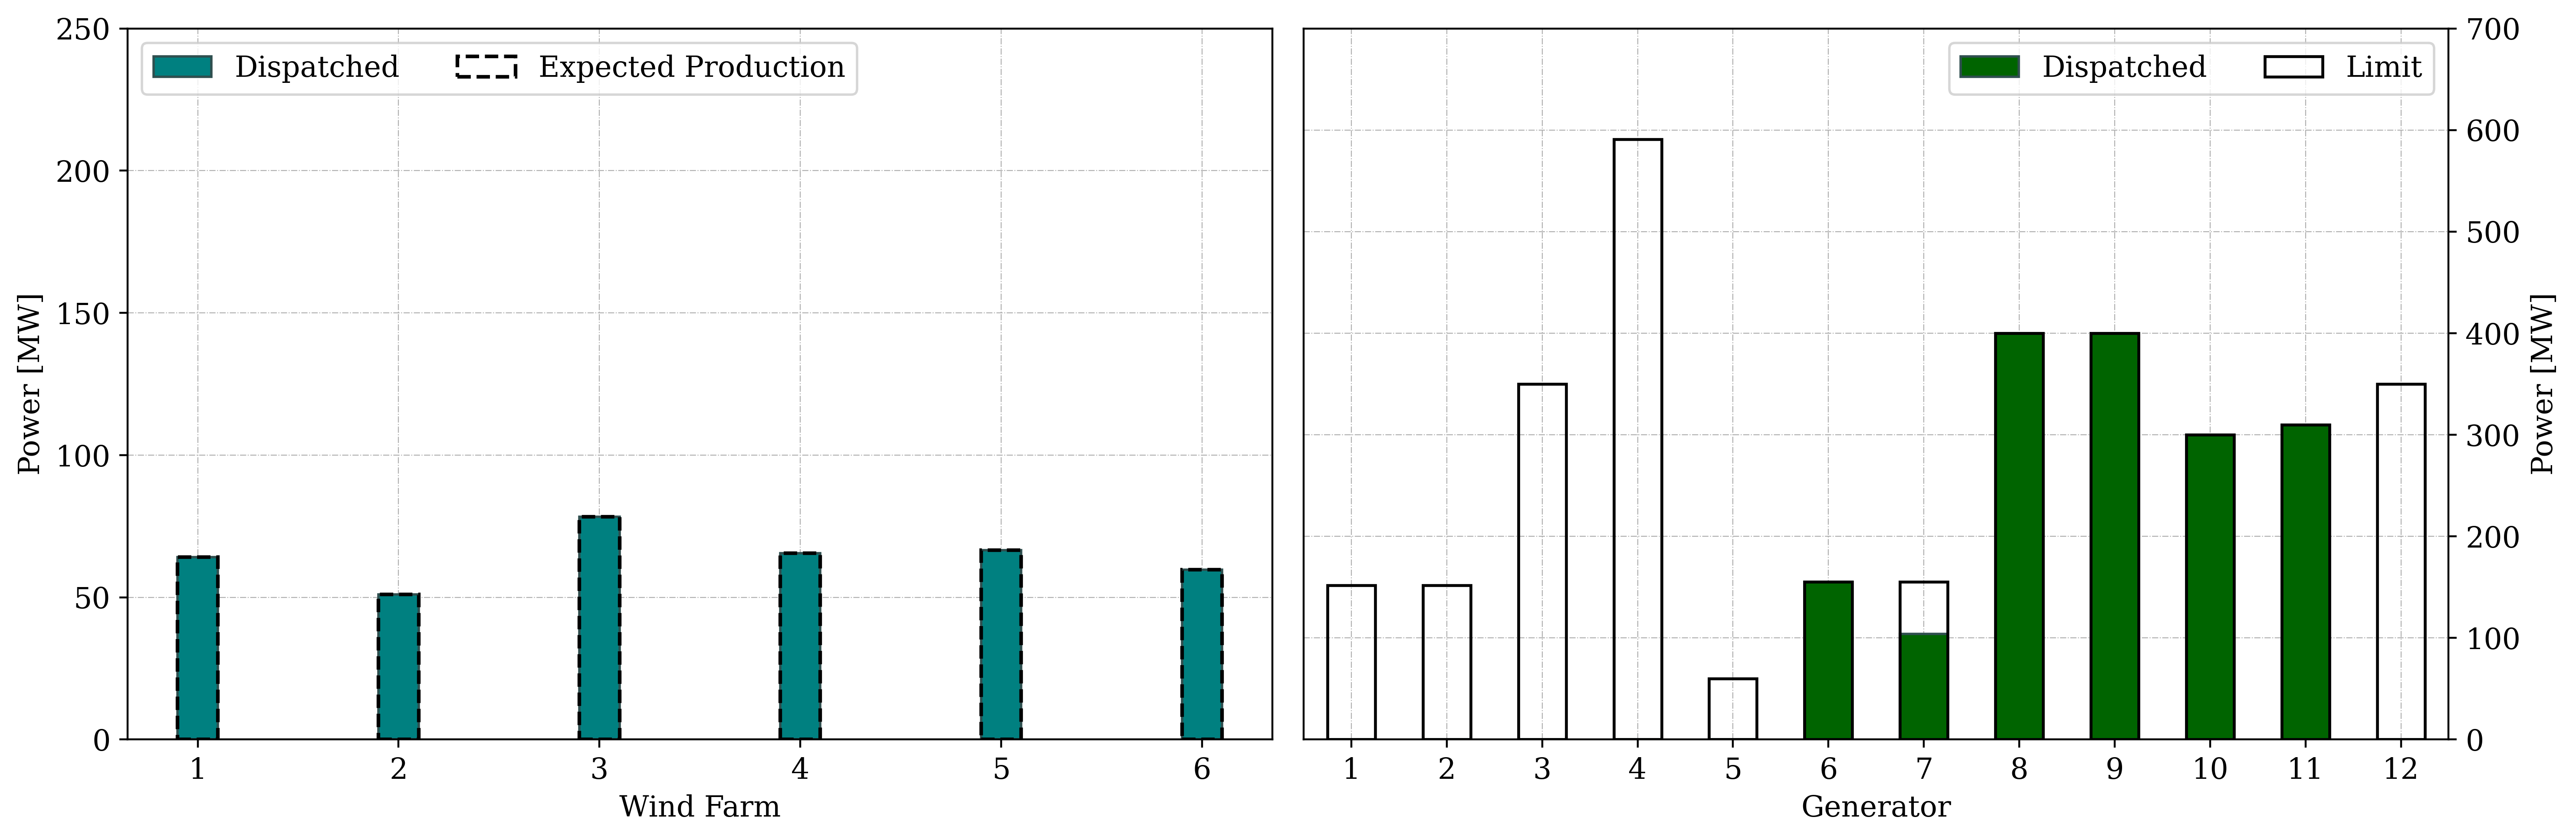

In [10]:
fig, ax = plt.subplots(1,2,sharey=False,figsize=( 15 , 5 ), dpi=400) # Create the figure

wind_data_formatted = wind_data.iloc[t, :].reset_index(drop=True).to_frame().rename(columns={t: 'Expected Production'})

#========== Plot wind farm results ==========
(generator_outputs.loc[generator_outputs.Type == 'Wind','p_G']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched', edgecolor='darkslategrey')
wind_data_formatted.plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=1.5, label='Expected Production')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, GW), labels = np.arange(1, GW + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=12)
ax[0].set_ylim([0,250])

#========== Plot conventional generator results ==========
(generator_outputs.loc[generator_outputs.Type == 'Conventional','p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
gen_data['P max MW'].plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, GC), labels = np.arange(1, GC + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper right', ncol=2, fontsize=12)
ax[1].set_ylim([0,700])

for k in range(2):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/task_1_results_gen_dispatch.png',bbox_inches='tight')
plt.show()

#### Demand Coverage

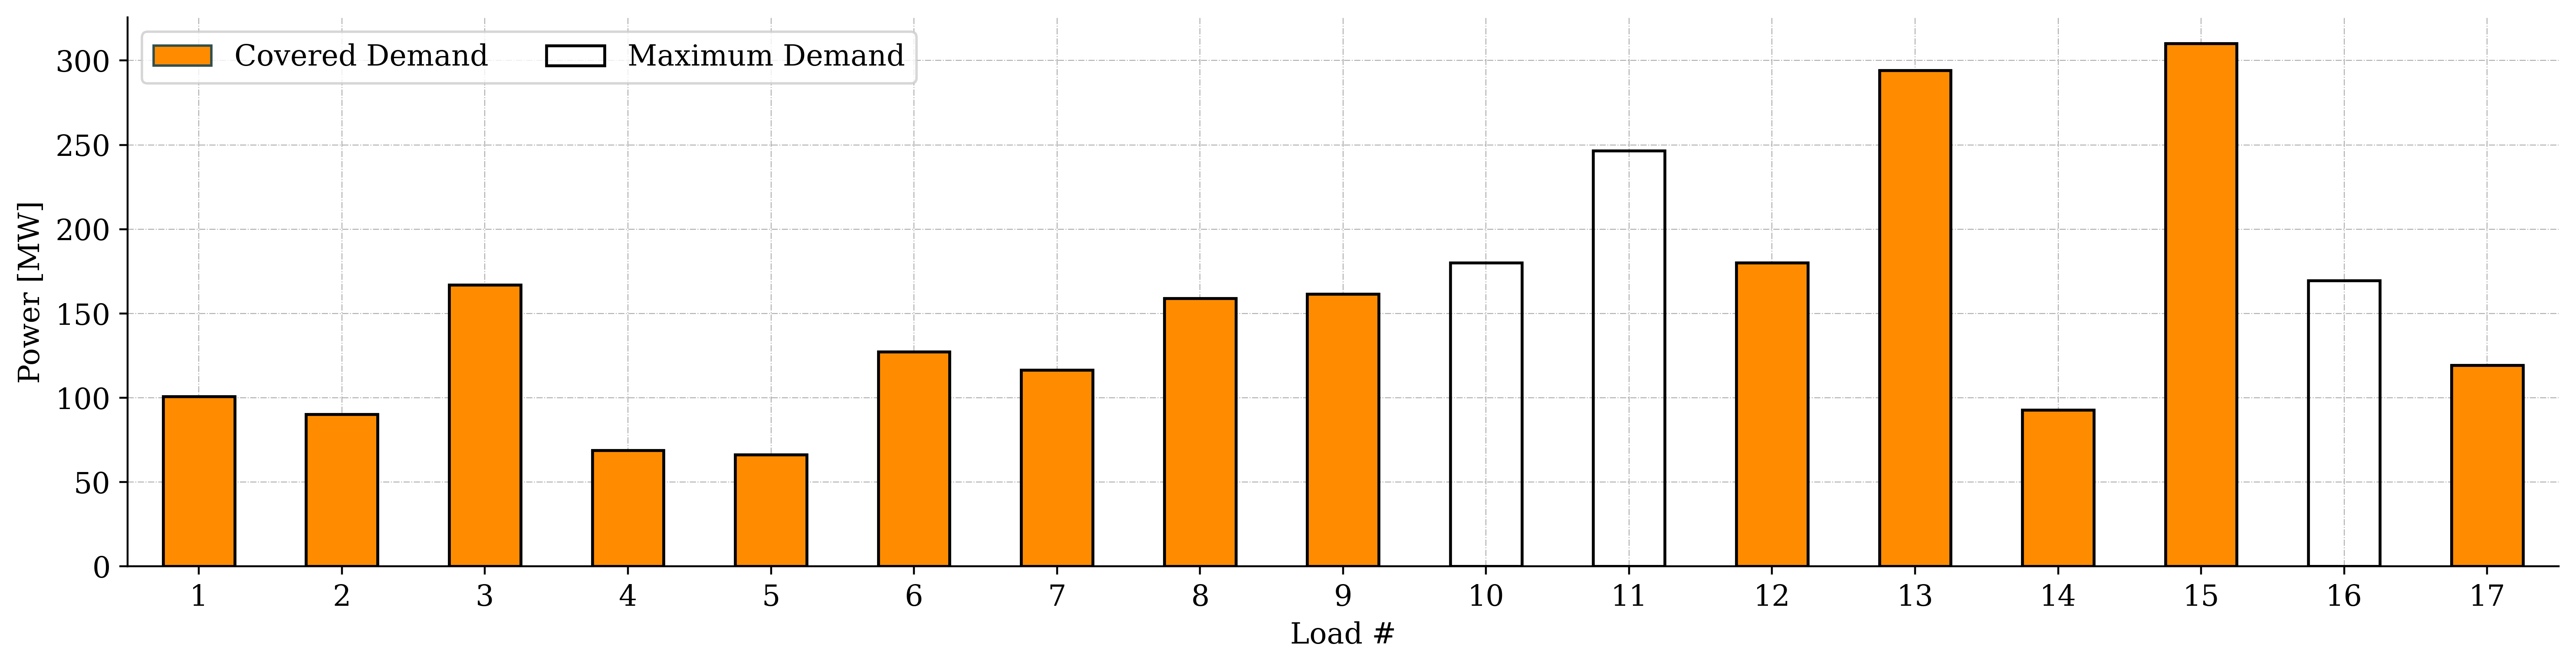

In [11]:
fig = plt.figure(figsize=( 15 , 4 ), dpi=400) # Create the figure
ax = fig.gca()

#========== Plot demand coverage ==========
results['demand']['p_D'].plot(kind='bar', ax=ax, color='darkorange', label='Covered Demand', edgecolor='darkslategrey')
results['demand']['Maximum Demand'].plot(kind='bar', ax=ax, edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Maximum Demand')

ax.set_ylabel('Power [MW]')
ax.set_xlabel('Load #')
ax.set_xticks(ticks = np.arange(0, D), labels = np.arange(1, D + 1), fontsize=12, rotation = 0)
ax.legend(loc='upper left', ncol=2, fontsize=12)

ax.set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/task_1_results_demand_coverage.png',bbox_inches='tight')
plt.show()

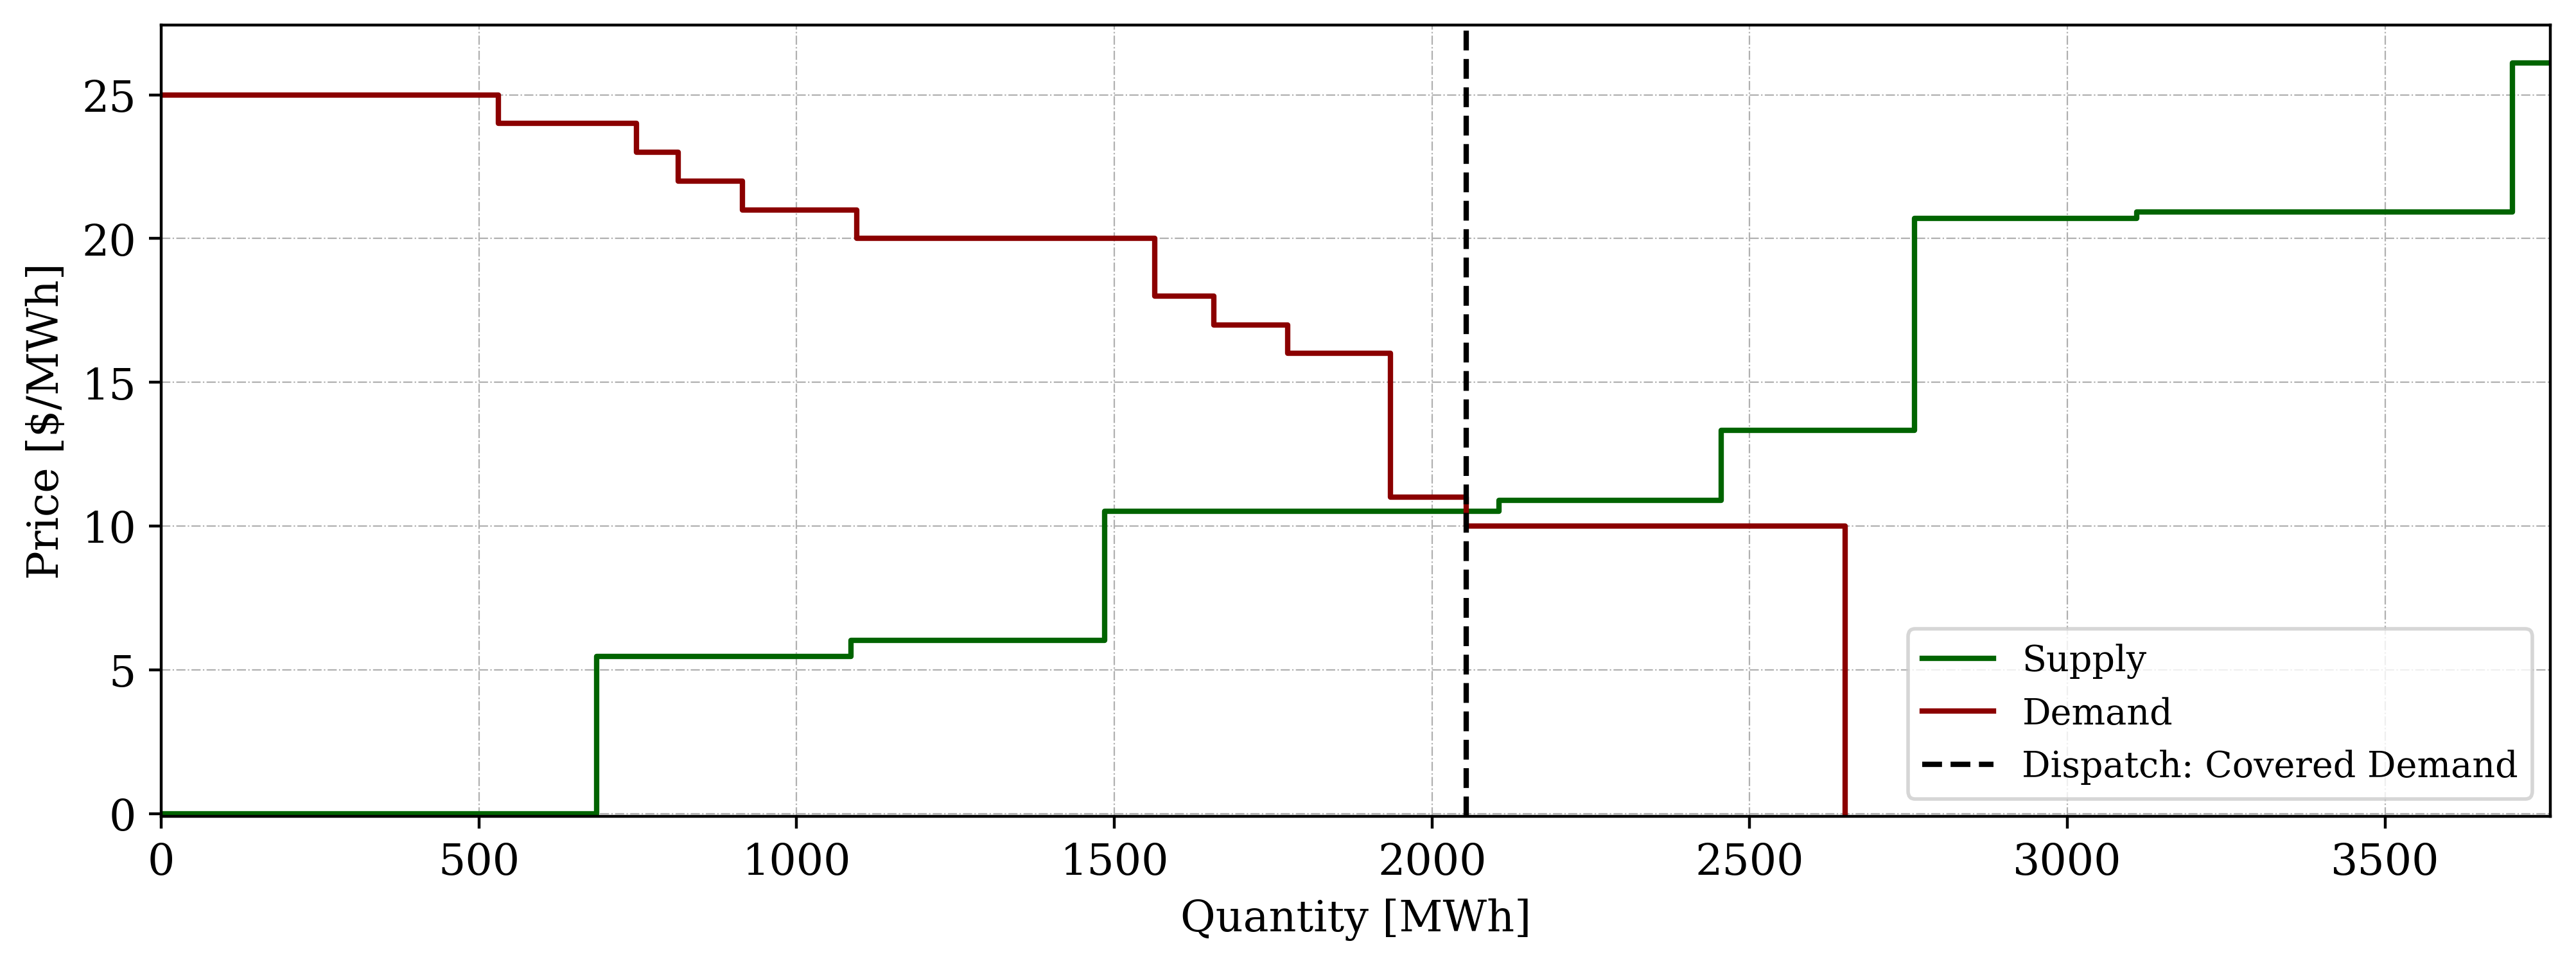

In [12]:
#=================== Demand Data ==========================
bid_pairs = pd.DataFrame() # pairing load demand and bid price 

# Filter the zeroes out using the mask
# mask = load != 0
# load = load[mask]

bid_pairs["load"] = load[load != 0]
bid_pairs["bid"] = bid_prices
sorted_bids = bid_pairs.sort_values(by='bid', ascending=False).reset_index(drop=True) # sort the prices from high to low
sorted_bids['cummulative_load'] = sorted_bids['load'].cumsum() # plotting SD-curves requires cummulative quantity values for the x-axis

#=================== Supply Data ==========================
offer_pairs = pd.DataFrame() # pairing gen. max capacity and offer price 
offer_pairs["capacity"] = gen_data['P max MW']
offer_pairs["offer"] = gen_costs['C ($/MWh)']
wind = wind_data.iloc[t,:].values
wind_final = pd.DataFrame(wind, columns=['capacity'])
wind_final["offer"] = 0
offer_pairs = pd.concat([offer_pairs, wind_final], axis = 0, ignore_index=False).reset_index(drop=True)
sorted_offers = offer_pairs.sort_values(by='offer', ascending=True).reset_index(drop=True) # sort the prices from low to high
sorted_offers['cummulative_capacity'] = sorted_offers['capacity'].cumsum() # plotting SD-curves requires cummulative quantity values for the x-axis

#============== Plotting supply-demand curves =============
fig, ax = plt.subplots(figsize=( 12 , 4 ), dpi=400) # Create the figure

#Supply
first_val = np.array([sorted_offers.iloc[0]['offer']]) #to make the first part visible
plt.step(np.concatenate([np.array([0]), sorted_offers['cummulative_capacity'].values]), 
         np.concatenate([first_val, sorted_offers['offer'].values]), 
         color='darkgreen', label='Supply', where='pre', linewidth=1.5)

#Demand
first_val = np.array([sorted_bids.iloc[0]['cummulative_load']]) #to make the first step visible
first_bid = np.array([sorted_bids.iloc[0]['bid']]) #to make the first step visible
last_val = np.array([sorted_bids.iloc[-1]['cummulative_load'] + 1e-9]) #to make the final step visible

plt.step(np.concatenate([np.array([0]), sorted_bids['cummulative_load'], last_val]),
         np.concatenate([first_bid, sorted_bids['bid'], np.array([0])]),
         color='darkred', label='Demand', where='pre', linewidth=1.5)

#Total covered demand as vertical line
plt.axvline(x=sum_load, color='black', linestyle='--', linewidth=1.5, label='Dispatch: Covered Demand')

ax.spines[['right', 'top']].set_visible(True)

#Formatting
plt.xlabel('Quantity [MWh]')
plt.ylabel('Price [$/MWh]')
#plt.title(f'Supply-Demand Curve for $t = {t+1}$')
plt.legend(loc='lower right', fontsize=10)
plt.ylim(ymin = -0.1)
plt.xticks(np.arange(0,4500 + 500, 500))
plt.margins(x=0)
plt.savefig('Figures/task_1_supply_demand_curve_hour_%d.png' % t, bbox_inches='tight')
plt.show()